In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import seaborn as sns

sns.set_theme(context='talk', 
              style='whitegrid', 
              palette='Set2',
              font_scale=1.4, 
              rc={'figure.figsize': (14, 6)})

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import plotly
pio.templates.default = 'plotly_white+presentation'



import scipy.optimize
import scipy.constants as sc

hbarc = sc.hbar*sc.speed_of_light/sc.giga/sc.electron_volt / sc.femto

from scipy.interpolate import InterpolatedUnivariateSpline


import json
import os
import glob

import sys
sys.path.append('../src')
from luscher_lib import Luscher_zeta, Kcot_luscher

from tqdm import tqdm

In [3]:
df_conf = pd.read_csv('../data/CLS_conf_inf.csv')
df_conf['a2 [fm2]'] = df_conf['a [fm]'].apply(lambda x: x**2)
df_conf['a_inv [GeV]'] = (hbarc / df_conf['a [fm]']).round(3) # add lattice unit
df_conf

Label  N_f  beta     kappa  size_L  size_T bdy.cond.  a [fm]  m_pi [MeV]  \
0  N300    3  3.70  0.137000      48     128      open  0.0498         422   
1  N202    3  3.55  0.137000      48     128      open  0.0642         412   
2  H200    3  3.55  0.137000      32      96      open  0.0642         419   
3  B450    3  3.46  0.136890      32      64  periodic  0.0762         417   
4  H101    3  3.40  0.136760      32      96      open  0.0865         417   
5  U103    3  3.40  0.136760      24     128      open  0.0865         414   
6  A653    3  3.34  0.136572      24      48  periodic  0.0992         424   
7    E5    2  5.30  0.136250      32      64  periodic  0.0658         436   
8    E1    2  5.30  0.135500      32      64  periodic  0.0658         978   

   L [fm]  m_pi L  m_B [GeV]  N_conf  N_tsrc  N_meas  N_LapH  a2 [fm2]  \
0     2.4     5.1       1.19    2047      12   24564      32  0.002480   
1     3.1     6.4       1.17     899       8   10788      68  0.004122   
2     2.1     4.4       1.19    2000       8   16000      20  0.004122   
3     2.4     5.2       1.18    1612       8   25762      32  0.005806   
4     2.8     5.9       1.16    2016       4   12096      48  0.007482   
5     2.1     4.4       1.18    5658       5   45264      20  0.007482   
6     2.4     5.1       1.16    5050       4   40400      32  0.009841   
7     2.1     4.7       1.29    2000       4   16000      30  0.004330   
8     2.1    10.4       2.03     168       8    2688      30  0.004330   

   a_inv [GeV]  
0        3.962  
1        3.074  
2        3.074  
3        2.590  
4        2.281  
5        2.281  
6        1.989  
7        2.999  
8        2.999

In [4]:
# for utility
lat_unit_dic = df_conf.set_index('Label')['a [fm]'].to_dict()
a_inv_dic = df_conf.set_index('Label')['a_inv [GeV]'].to_dict()
L_fm_dic = df_conf.set_index('Label')['L [fm]'].to_dict()
L_dic = df_conf.set_index('Label')['size_L'].to_dict()
pion_mass_dic = df_conf.set_index('Label')['m_pi [MeV]'].to_dict()
baryon_mass_dic = df_conf.set_index('Label')['m_B [GeV]'].to_dict()
label_list = list(df_conf['Label'])


# E1 conf. & E5 conf.

In [5]:
ld_dic = {}
for fname in glob.glob('../data/pcot_p2/E*.json'):
    with open(fname, 'r') as fin:
        tmp = json.load(fin)
        ld_dic[(tmp.get('label'), tmp.get('frame'), tmp.get('level'))] = tmp

In [6]:
ld_dic.keys()

dict_keys([('E5', 'P001', 0), ('E5', 'P011', 1), ('E1', 'P000', 0), ('E5', 'P011', 0), ('E1', 'P000', 1), ('E5', 'P001', 1), ('E1', 'P011', 1), ('E5', 'P000', 0), ('E1', 'P001', 0), ('E1', 'P001', 1), ('E1', 'P011', 0), ('E5', 'P000', 1), ('E1', 'P002', 0), ('E1', 'P111', 0), ('E1', 'P111', 1), ('E5', 'P111', 0), ('E5', 'P002', 0), ('E5', 'P111', 1)])

In [7]:
color_list = {'P000': 'dimgray', 'P001': 'firebrick', 'P011': 'darkorange', 'P111': 'mediumturquoise', 'P002': 'ghostwhite'}


[(-0.5, 0.5),
 (-0.2, 0.5),
 Text(0.5, 0, '$(p/m_\\pi)^2$'),
 Text(0, 0.5, '$p\\cot\\delta/m_\\pi$'),
 Text(0.5, 1.0, 'E1 ($m_\\pi = 978$ [MeV], $La = 2.1$ [fm], $a = 0.0658$ [fm])')]

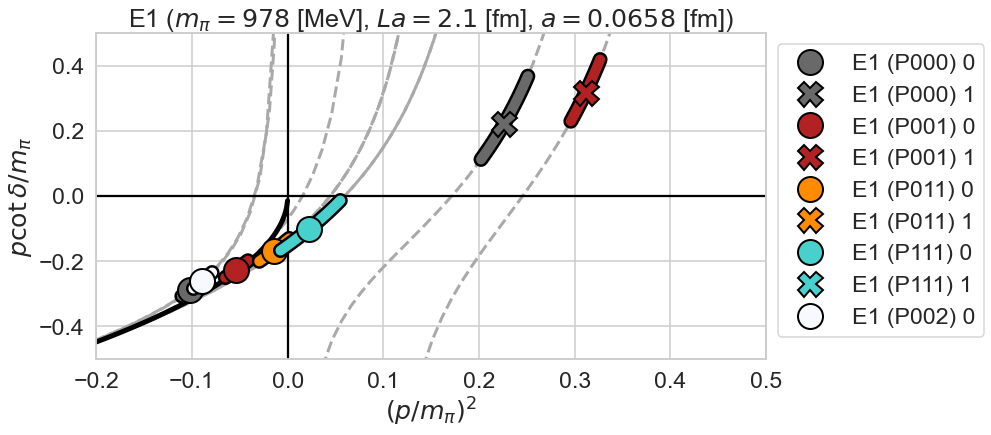

In [8]:
xlim = (-0.2, 0.5)
ylim = (-0.5, 0.5)
label = 'E1'

fig, ax = plt.subplots(figsize=(12, 6))

for frame in ['P000', 'P001', 'P011', 'P111', 'P002']:
    c = color_list.get(frame)
    for level in [0, 1]:
        try:
            ld = ld_dic[(label, frame, level)]

            ax.plot(ld.get('k2mpi2s'), ld.get('kcot_mpis'), color='black', zorder=3, lw=15)
            ax.plot(ld.get('k2mpi2s'), ld.get('kcot_mpis'), color=c, zorder=3, lw=10)

            sym = {0: 'o', 1: 'X'}[level]
            ax.plot(ld.get('k2mpi2'), ld.get('kcot_mpi'), sym, ms=25, color=c, mec='black', mew=2, zorder=3, label=f'{label} ({frame}) {level}')
            ax.plot(ld.get('k2mpi2_ref'), ld.get('kcot_mpi_ref'), ls='--', lw=3, color='darkgray')


        except:
            pass

if xlim[0] < 0:
    xbs = np.concatenate([np.linspace(xlim[0], -0.5e-1), np.linspace(-0.5e-1, -2e-4)])
    ax.plot(xbs, - np.sqrt(-xbs), color='black', ls='-', lw=5)

ax.legend(loc='upper left', bbox_to_anchor=(1,1))
ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.set(ylim=ylim, xlim=xlim, xlabel=r'$(p/m_\pi)^2$', ylabel=r'$p\cot\delta/m_\pi$',
      title=rf'{label} ($m_\pi = {pion_mass_dic.get(label)}$ [MeV], $La = {L_fm_dic.get(label)}$ [fm], $a = {lat_unit_dic.get(label)}$ [fm])')


In [9]:
class ERE_fitting(object):
    def __init__(self, label, xlim, ylim):
        """
        label : ex. 'N300'
        xlim : (-xmin, xmax)
        ylim : (-ymin, ymax)
        """
        self.label = label
        self.xlim = xlim
        self.ylim = ylim
    
    
    def check_ERE_intersection(self, ere_prm):
        """
        ere_prm : [1/a0, reff] in pion mass unit
        """
        ere = lambda k2: ere_prm[0] + 0.5*ere_prm[1]*k2

        color_list = {'P000': 'dimgray', 'P001': 'firebrick', 'P011': 'darkorange', 'P111': 'mediumturquoise', 'P002': 'ghostwhite'}

        xbs = np.concatenate([np.linspace(self.xlim[0], -0.5e-1), np.linspace(-0.5e-1,-2e-4)])

        fig = go.Figure()

        fig.add_hline(y=0, line_width=3)
        fig.add_vline(x=0, line_width=3)

        fig.add_trace(
            go.Scatter(x=xbs, y=-np.sqrt(-xbs), mode='lines',
                      line=dict(color='black', width=5), name='bound state condition', showlegend=False)
        )

        chisq = 0

        for frame in ['P000', 'P001', 'P011', 'P111' ,'P002']:
            c = color_list.get(frame)
            for level in [0, 1]:

                try:
                    ld = ld_dic[(self.label, frame, level)]

                    sym={0:'circle', 1:'x', 2:'triangle-up'}[level]

                    lbl = f'{label} ({frame}) n={level}'

                    xs, ys = np.array(ld.get('k2mpi2_ref')), np.array(ld.get('kcot_mpi_ref'))
                    ymsk = (ys > ylim[0]) & (ys < ylim[1])
                    ll = InterpolatedUnivariateSpline(xs[ymsk], ys[ymsk])

                    intersect = lambda k2: ere(k2) - ll(k2)
                    sol = scipy.optimize.root(intersect, ld.get('k2mpi2'))

                    fig.add_traces(
                        [
                            go.Scatter(x=ld.get('k2mpi2_ref'), y=ld.get('kcot_mpi_ref'), mode='lines',
                                            line=dict(dash='dash', color='gray', width=2), legendgroup=lbl, name='FV constraints', showlegend=False,
                                           hovertemplate='(%{x:.3f}, %{y:.3f})'),
                            go.Scatter(x=ld.get('k2mpi2s'), y=ld.get('kcot_mpis'), mode='lines',
                                      line=dict(color='black', width=12), legendgroup=lbl, name='95CI',
                                      hovertemplate='(%{x:.3f}, %{y:.3f})', showlegend=False),
                            go.Scatter(x=ld.get('k2mpi2s')[2:-2], y=ld.get('kcot_mpis')[2:-2], mode='lines',
                                      line=dict(color=c, width=8), legendgroup=lbl, name='95CI',
                                      hovertemplate='(%{x:.3f}, %{y:.3f})', showlegend=False),
                            go.Scatter(x=[ld.get('k2mpi2')], y=[ld.get('kcot_mpi')], mode='markers',
                                       hovertemplate=lbl+'<br>(%{x:.3f}, %{y:.3f})', showlegend=True,
                                        marker=dict(color=c, size=25, symbol=sym,
                                                   line=dict(width=2, color='black')), legendgroup=lbl, name=lbl)
                        ]
                    )
                    if sol.success:
                        assert len(sol.x) == 1
                        if sol.x[0] < ld.get('k2mpi2'):
                            chisq += (sol.x[0] - ld.get('k2mpi2'))**2/(ld.get('k2mpi2') - np.min(ld.get('k2mpi2s')))**2
                        else:
                            chisq += (sol.x[0] - ld.get('k2mpi2'))**2/(np.max(ld.get('k2mpi2s')) - ld.get('k2mpi2'))**2

                        fig.add_trace(go.Scatter(x=sol.x, y=ere(sol.x), mode='markers', 
                                                 marker=dict(color='royalblue', size=25, symbol='x',
                                                            line=dict(width=3, color='white')), showlegend=False, legendgroup=lbl, name='intersect'))
                    else:
                        chisq = np.nan
                except:
                    pass

        xls = np.linspace(self.xlim[0], self.xlim[1])
        fig.add_trace(
            go.Scatter(x=xls, y=ere(xls), mode='lines', line=dict(color='royalblue', width=5), name=f'ERE chi square = {chisq:.2f}')
        )

        fig.update_layout(
            title=f'$\LARGE{{\mathrm{{{label}}} \ (m_\pi = {pion_mass_dic.get(label)} \ [\mathrm{{MeV}}], \ La = {L_fm_dic.get(label)} \ [\mathrm{{fm}}], a = {lat_unit_dic.get(label)} \ [\mathrm{{fm}}])}}$',
            xaxis_title='$\LARGE{(p/m_\pi)^2}$', 
                         yaxis_title='$\LARGE{p\cot\delta/m_\pi}$',
                         xaxis_range=self.xlim, yaxis_range=self.ylim,
                         font=dict(size=32))
        return fig
    
    def ERE_fit_and_plot_params(self, a0inv_lim, reff_lim, mesh_num=100):
        a0invs = np.linspace(a0inv_lim[0], a0inv_lim[1], mesh_num)
        reffs = np.linspace(reff_lim[0], reff_lim[1], mesh_num)
        
        chisq_ere = np.array([[self._calc_ERE_chisq([a0inv, reff]), a0inv, reff] for a0inv in a0invs for reff in reffs])
        
        
        fig, ax = plt.subplots()

        chisq_min, a0inv0, reff0 = chisq_ere[np.nanargmin(chisq_ere[:,0]),:]
        ax.plot(a0inv0, reff0, 'X', color='blue', mew=2, mec='white', ms=35,
               label=f'({a0inv0:.2f}, {reff0:.2f})')

        zz = np.copy(chisq_ere[:,:].reshape(mesh_num,mesh_num,3))
        mask = zz[:,:,0] > chisq_min + 2.3 # for 2 parameters
        zz[:,:,0][mask] = np.nan

        cb = ax.contourf(zz[:,:,1], zz[:,:,2], zz[:,:,0]-chisq_min, np.linspace(0, 0+2.3,100),
                        cmap=cm.inferno)
        cb.set_clim(0,2.3)
        fig.colorbar(cb, ticks=[0,0.5,1.0,1.5,2.0])

        self.k2ast_av = self.EREprm_to_k2ast(a0inv0, reff0)
        mask2 = chisq_ere[:,0] <= chisq_min + 2.3
        k2ast_bs = self.EREprm_to_k2ast(chisq_ere[mask2,1],chisq_ere[mask2,2])
        self.k2ast_lower, self.k2ast_upper = np.min(k2ast_bs), np.max(k2ast_bs)
        
        self.BE_av = self.k2ast_to_BE(self.k2ast_av)
        self.BE_lower = self.k2ast_to_BE(self.k2ast_upper)
        self.BE_upper = self.k2ast_to_BE(self.k2ast_lower)
        

        ax.set_title(rf'{label} ERE parameter $\chi^2 - \chi^2_\mathrm{{min}}(={chisq_min:.2f})$'
            + '\n' + rf'$\mathrm{{B.E.}} = {self.BE_av:.2f}(_{{{self.BE_lower-self.BE_av:+.2f}}}^{{{self.BE_upper-self.BE_av:+.2f}}})$ [MeV]')
        ax.set_xlabel(r'$(a_0m_\pi)^{-1}$')
        ax.set_ylabel(r'$r_\mathrm{eff}m_\pi$')
        leg = ax.legend(frameon=True)
        leg.get_frame().set_edgecolor('black')
        leg.get_frame().set_linewidth(2.0)
        
        fig.savefig(f'../figs/ERE/{self.label}_ERE_parameter.png', bbox_inches='tight')
        
        
        self.chisq_ere = chisq_ere
        
        return self.BE_av, self.BE_lower, self.BE_upper
        
        
    def plot_k2_vs_kcot_with_ERE(self, xlim, ylim, suffix=''):
        ere_k2s = np.linspace(xlim[0], xlim[1])
        mask = self.chisq_ere[:,0] <= np.nanmin(self.chisq_ere[:,0]) + 2.3
        ere_upper = []
        ere_lower = []
        allowed_a0invs = self.chisq_ere[mask,1]
        allowed_reffs = self.chisq_ere[mask,2]
        ere_t = lambda p0, p1, k2: p0 + 0.5*p1*k2

        for k2 in ere_k2s:
            ere_upper.append(np.max(ere_t(allowed_a0invs, allowed_reffs, k2)))
            ere_lower.append(np.min(ere_t(allowed_a0invs, allowed_reffs, k2)))

        
        color_list = {'P000': 'dimgray', 'P001': 'firebrick', 'P011': 'darkorange', 'P111': 'mediumturquoise', 'P002': 'ghostwhite'}


        fig, ax = plt.subplots(figsize=(12,6))

        for frame in ['P000', 'P001', 'P011', 'P111', 'P002']:
            c = color_list.get(frame)
            
            for level in [0, 1]:
                if (level == 1) & (frame == 'P002'): continue

                ld = ld_dic[(self.label, frame, level)]

                ax.plot(ld.get('k2mpi2s'), ld.get('kcot_mpis'), color='black', zorder=3, lw=15)
                ax.plot(ld.get('k2mpi2s'), ld.get('kcot_mpis'), color=c, zorder=3, lw=10)

                sym = {0: 'o', 1: 'X'}[level]
                ax.plot(ld.get('k2mpi2'), ld.get('kcot_mpi'), sym, ms=25, color=c, mec='black', mew=2, zorder=3, 
                        label=f'{self.label} ({frame})')
                ax.plot(ld.get('k2mpi2_ref'), ld.get('kcot_mpi_ref'), ls='--', lw=3, color='darkgray')


        ax.fill_between(ere_k2s, ere_upper, ere_lower, color='royalblue', alpha=0.2, zorder=3, label='ERE')
        ax.plot(ere_k2s, ere_upper, color='royalblue', lw=1, zorder=3)
        ax.plot(ere_k2s, ere_lower, color='royalblue', lw=1, zorder=3)


        xbs = np.concatenate([np.linspace(xlim[0], -0.5e-1), np.linspace(-0.5e-1, -2e-4)])
        ax.plot(xbs, - np.sqrt(-xbs), color='black', ls='-', lw=5)
        
        ax.plot(self.k2ast_av, - np.sqrt(-self.k2ast_av), 'P', ms=25, color='palegreen', zorder=5, mew=2, mec='black',
               label=rf'${self.BE_av:.2f}(_{{{self.BE_lower - self.BE_av:+.2f}}}^{{{self.BE_upper-self.BE_av:+.2f}}})$ [MeV]')
        k2asts = np.linspace(self.k2ast_lower, self.k2ast_upper)
        ax.plot(k2asts, - np.sqrt(-k2asts), lw=15, color='black')
        ax.plot(k2asts, - np.sqrt(-k2asts), lw=10, color='palegreen')

        ax.legend(loc='upper left', bbox_to_anchor=(1,1))
        ax.axhline(0, color='black')
        ax.axvline(0, color='black')
        ax.set(ylim=ylim, xlim=xlim, xlabel=r'$(p/m_\pi)^2$', ylabel=r'$p\cot\delta/m_\pi$',
              title=rf'{self.label} ($m_\pi = {pion_mass_dic.get(self.label)}$ [MeV], $La = {L_fm_dic.get(self.label)}$ [fm], $a = {lat_unit_dic.get(self.label)}$ [fm])')
        fig.savefig(f'../figs/ERE/{self.label}_pcot_vs_p2_ERE_fit{suffix}.png', bbox_inches='tight') # , transparent=True)
        
    
    def _calc_ERE_chisq(self, ere_prm):
        ere = lambda k2: ere_prm[0] + 0.5*ere_prm[1]*k2

        chisq = 0

        for frame in ['P000', 'P001', 'P011', 'P111' ,'P002']:
            for level in [0, 1]:
                
                if (level == 1) & (frame == 'P011'): continue
                    
                if (level == 1) & (frame == 'P111'): continue
                    
                if (level == 1) & (frame == 'P002'): continue
            
                try:
                    ld = ld_dic[(self.label, frame, level)]

                    xs, ys = np.array(ld.get('k2mpi2_ref')), np.array(ld.get('kcot_mpi_ref'))
                    ymsk = (ys > self.ylim[0]) & (ys < self.ylim[1])
                    ll = InterpolatedUnivariateSpline(xs[ymsk], ys[ymsk])

                    intersect = lambda k2: ere(k2) - ll(k2)
                    sol = scipy.optimize.root(intersect, ld.get('k2mpi2'))

                    if sol.success:
                        assert len(sol.x) == 1
                        if sol.x[0] < ld.get('k2mpi2'):
                            chisq += (sol.x[0] - ld.get('k2mpi2'))**2/(ld.get('k2mpi2') - np.min(ld.get('k2mpi2s')))**2
                        else:
                            chisq += (sol.x[0] - ld.get('k2mpi2'))**2/(np.max(ld.get('k2mpi2s')) - ld.get('k2mpi2'))**2
                    else:
                        chisq = np.nan
                except:
                    pass

        return chisq
    

    def EREprm_to_k2ast(self, a0inv, reff):
        """
        return intersection between ERE and binding state condition in pion mass unit
        """
        k2ast = (-2*(reff*a0inv + 1) + 2 * np.sqrt((reff*a0inv+1)**2 - reff**2*a0inv**2))/(reff**2)
        
        return k2ast
        
    def k2ast_to_BE(self, k2ast):
        
        return  - (
            2 * np.sqrt(k2ast*pion_mass_dic.get(self.label)**2 + (baryon_mass_dic.get(self.label)*1e3)**2) 
            - 2 * baryon_mass_dic.get(self.label)*1e3
        )

## ERE fitting

In [10]:
BE_dic = {}

In [11]:
label = 'E1'
xlim, ylim = (-0.2, 0.35), (-0.5, 0.5)

ef = ERE_fitting(label, xlim, ylim)

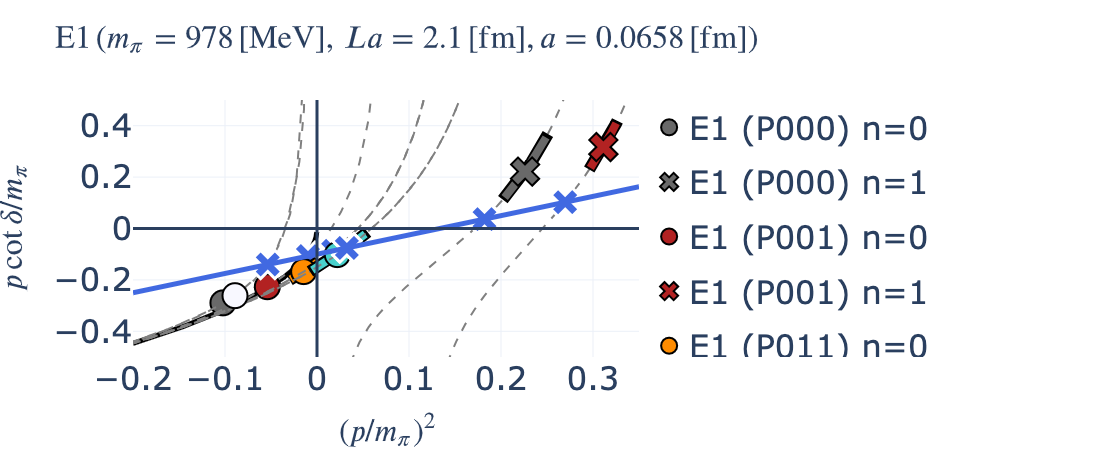

In [12]:
ere_prm = (-0.1, 1.5)
ef.check_ERE_intersection(ere_prm)

CPU times: user 20.8 s, sys: 185 ms, total: 20.9 s
Wall time: 26.5 s


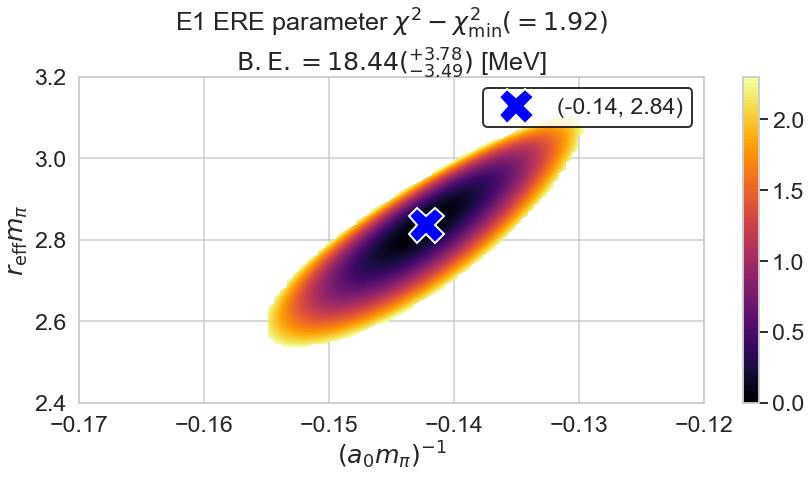

In [13]:
%%time
BE_dic[label] = ef.ERE_fit_and_plot_params((-0.17, -0.12), (2.4, 3.2), mesh_num=100)

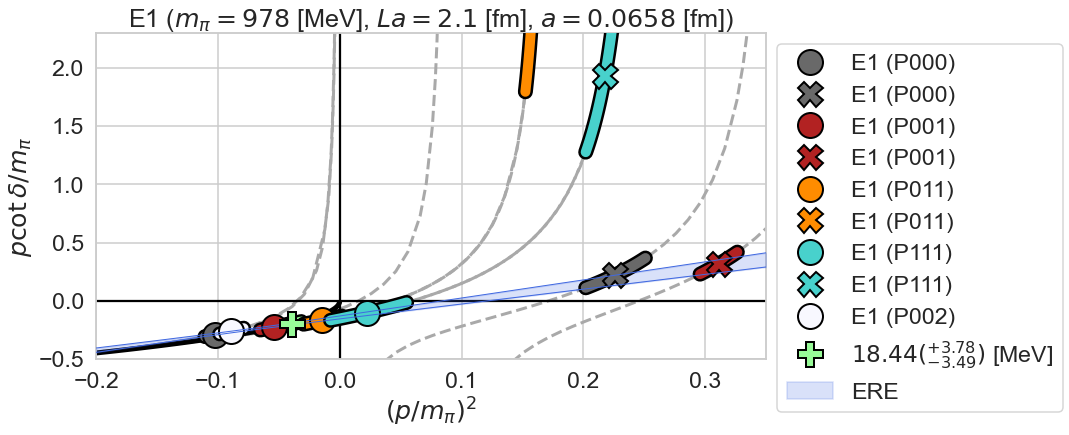

In [14]:
ef.plot_k2_vs_kcot_with_ERE(xlim, ylim=(-0.5, 2.3))

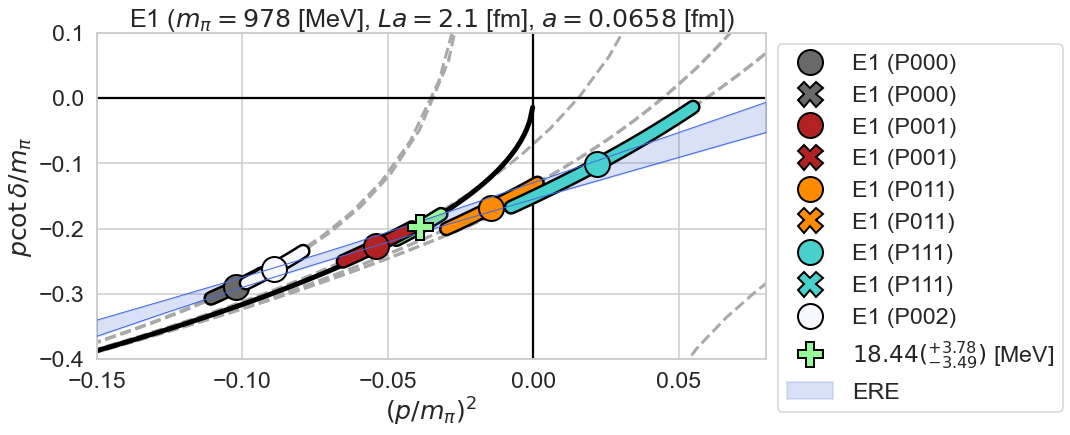

In [15]:
ef.plot_k2_vs_kcot_with_ERE(xlim=(-0.15, 0.08), ylim=(-0.4, 0.1), suffix='_neg')

## E5

In [16]:
label = 'E5'
xlim, ylim = (-0.8, 2.5), (-1, 5.5)

ef = ERE_fitting(label, xlim, ylim)

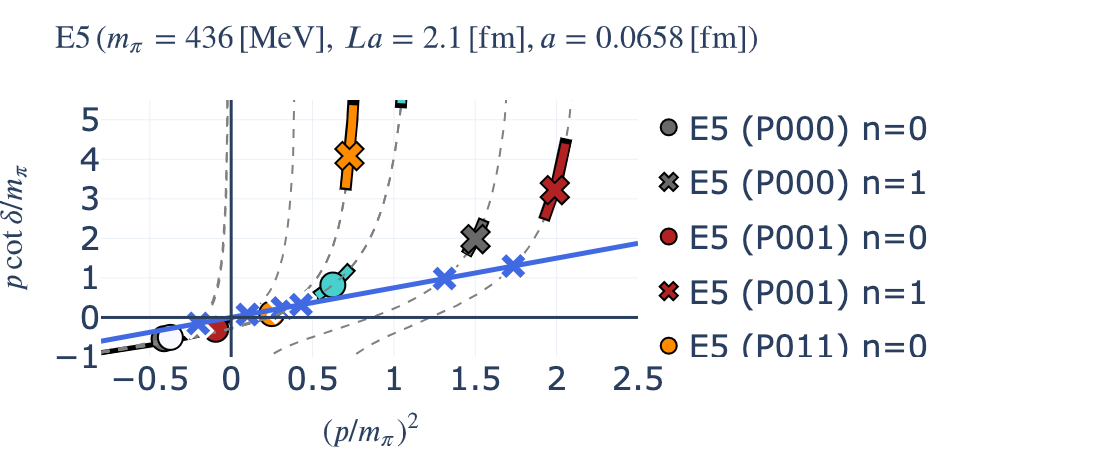

In [17]:
ere_prm = (0., 1.5)
ef.check_ERE_intersection(ere_prm)

CPU times: user 22.2 s, sys: 168 ms, total: 22.4 s
Wall time: 26 s


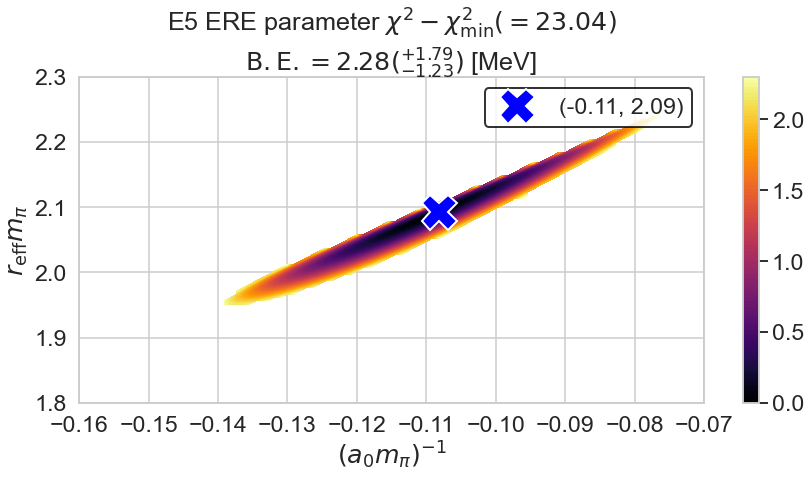

In [18]:
%%time
BE_dic[label] = ef.ERE_fit_and_plot_params((-0.16, -0.07), (1.8, 2.3), mesh_num=100)

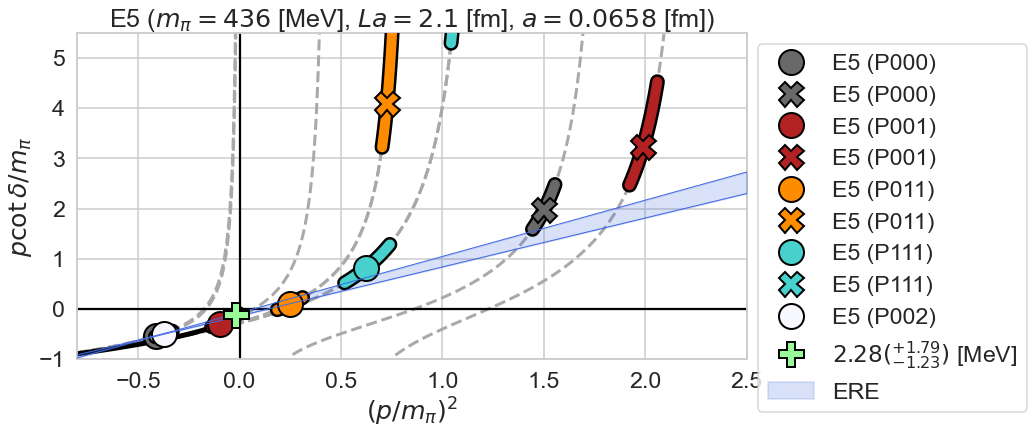

In [19]:
ef.plot_k2_vs_kcot_with_ERE(xlim=(-0.8, 2.5), ylim=(-1, 5.5))

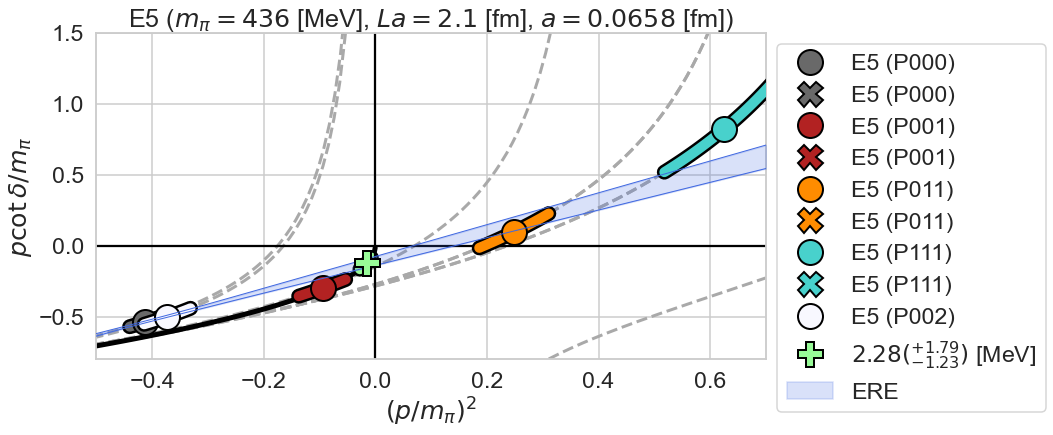

In [20]:
ef.plot_k2_vs_kcot_with_ERE(xlim=(-0.5, 0.7), ylim=(-0.8, 1.5), suffix='_neg')